## Think Bayes 2, Ch. 4
Suppose you want to test whether a coin is fair, but you don’t want to spin it hundreds of times. So you make a machine that spins the coin automatically and uses computer vision to determine the outcome.

However, you discover that the machine is not always accurate. Specifically, suppose the probability is y=0.2 that an actual heads is reported as tails, or actual tails reported as heads.

If we spin a coin 250 times and the machine reports 140 heads, what is the posterior distribution of x? What happens as you vary the value of y?


# Coin Fairness with Misclassification: Strong Prior, ROPE, and Bayes Factors

We test whether a coin is fair when the **reporting machine is noisy** with a symmetric misclassification rate $y$:
- If the true face is Head, the machine reports Tail with prob $y$.
- If the true face is Tail, the machine reports Head with prob $y$.

Let $\theta = \Pr(\text{Head})$ be the **true** probability of Head. The probability the machine **reports** Head is
$$
q \;=\; y + (1 - 2y)\,\theta.
$$
Given $r$ reported heads out of $N$ trials, 
$$
    r \sim \mathrm{Binomial}(N, q).
$$


**This notebook uses a strong prior** 
$$
\theta\sim\mathrm{Beta}(10,10)
$$ 
misclassification rate $y=0.4$, and data $N=250, r=140$. We compute the posterior of $\theta$, Bayes factors for fairness, and ROPE-based decisions.



## Concepts used in this notebook

### ROPE — Region Of Practical Equivalence
**Goal:** Decide if $\theta$ is *practically indistinguishable* from a target $\theta_0$ (here, fairness $\theta_0=0.5$).  
Pick a tolerance interval (the ROPE), e.g. $[0.48, 0.52]$ for $\pm 0.02$ or $[0.45, 0.55]$ for $\pm 0.05$.  
From posterior draws of $\theta$, compute:
- $P(\theta \in \text{ROPE})$, $P(\theta<\text{low})$, $P(\theta>\text{high})$.

**Heuristic decisions (Kruschke):**
- If $P(\theta\in\text{ROPE})>0.95$ ⇒ accept practical equivalence.
- If $P(\theta\in\text{ROPE})<0.05$ ⇒ reject practical equivalence (practically different).
- Otherwise ⇒ inconclusive.

ROPE addresses *practical* (not merely point-null) equivalence. Set the width based on domain tolerance.

### Bayes Factor (BF)
Comparative evidence for models/hypotheses:
$$
\mathrm{BF}_{10}=\frac{p(\text{data}\mid H_1)}{p(\text{data}\mid H_0)}, \quad \mathrm{BF}_{01}=\frac{1}{\mathrm{BF}_{10}}.
$$
Here:
- $H_0$: $\theta=0.5$ (fair); then $q=0.5$.
- $H_1$: $\theta\sim\mathrm{Beta}(10,10)$.

**Interpretation (rough guide):** 1–3 anecdotal, 3–10 moderate, 10–30 strong, >30 very strong — but always check prior sensitivity.


## Stan model

In [9]:
#'\n// coin_misclass.stan\ndata {\n  int<lower=0> N;              // number of flips\n  int<lower=0, upper=N> r;     // reported heads\n  real<lower=0, upper=0.5> y;  // symmetric misclassification prob\n  real<lower=0> alpha;         // Beta prior on theta: alpha\n  real<lower=0> beta;          // Beta prior on theta: beta\n}\nparameters {\n  real<lower=0, upper=1> theta; // true head probability\n}\ntransformed parameters {\n  real<lower=0, upper=1> q;\n  q = y + (1 - 2 * y) * theta;  // reported-head probability\n}\nmodel {\n  theta ~ beta(alpha, beta);\n  r ~ binomial(N, q);\n}\ngenerated quantities {\n  int r_rep = binomial_rng(N, q);                 // posterior predictive\n  real<lower=0, upper=1> theta_via_q = (q - y) / (1 - 2 * y); // identity, for clarity\n}\n'

stan_code = \
"""
data {
  int<lower=0> N;
  int<lower=0, upper=N> r;
  real<lower=0, upper=0.5> y;  // set to 0.4
  real<lower=0> alpha;
  real<lower=0> beta;
}
parameters { real<lower=0, upper=1> theta; }
transformed parameters {
  real<lower=0, upper=1> q;
  q = y + (1 - 2*y) * theta;
}
model {
  theta ~ beta(alpha, beta);
  r ~ binomial(N, q);
}
generated quantities {
  int r_rep = binomial_rng(N, q);
  real<lower=0, upper=1> theta_via_q = (q - y) / (1 - 2*y);
}
"""

In [11]:

from pathlib import Path
stan_path = Path("coin_misclass.stan")
stan_path.write_text(stan_code)
print("Wrote", stan_path.resolve())


Wrote /Users/yndk/Desktop/KOS6002/RRT/coin_misclass.stan



## Setup (one-time)
If needed, install CmdStan and packages:
```bash
pip install cmdstanpy arviz matplotlib
python -c "from cmdstanpy import install_cmdstan; install_cmdstan()"
```


## Fit with CmdStanPy (strong prior α=10, β=10, y=0.4)

In [12]:

from cmdstanpy import CmdStanModel
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data & prior
N, r = 250, 140
y = 0.4
alpha, beta = 1.0, 1.0

model = CmdStanModel(stan_file="coin_misclass.stan")
fit = model.sample(
    data=dict(N=N, r=r, y=y, alpha=alpha, beta=beta),
    seed=2025, chains=4, parallel_chains=4,
    iter_warmup=1000, iter_sampling=1000, adapt_delta=0.95,
)
print(fit.diagnose())

draws = fit.draws_pd()
idata = az.from_cmdstanpy(posterior=fit)
az.summary(idata, var_names=["theta", "q"], round_to=4)


00:32:01 - cmdstanpy - INFO - compiling stan file /Users/yndk/Desktop/KOS6002/RRT/coin_misclass.stan to exe file /Users/yndk/Desktop/KOS6002/RRT/coin_misclass
00:32:04 - cmdstanpy - INFO - compiled model executable: /Users/yndk/Desktop/KOS6002/RRT/coin_misclass
00:32:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:32:05 - cmdstanpy - INFO - CmdStan done processing.



Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.7579,0.1417,0.5176,0.9996,0.0045,0.0034,844.8122,539.5436,1.0039
q,0.5516,0.0283,0.5035,0.5999,0.0009,0.0007,844.8122,539.5436,1.0039


## Posterior and Posterior Predictive (discrete PMF)

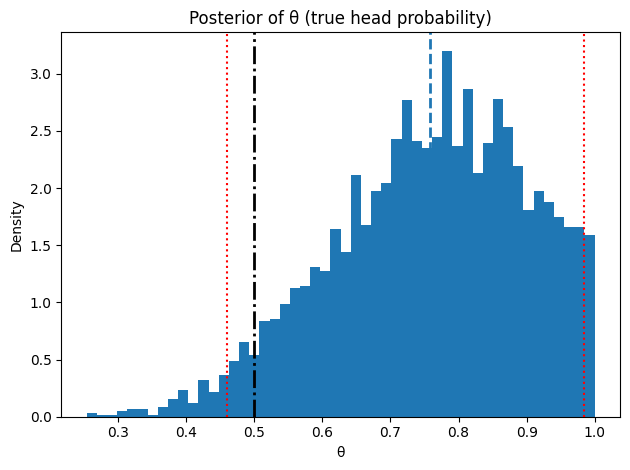

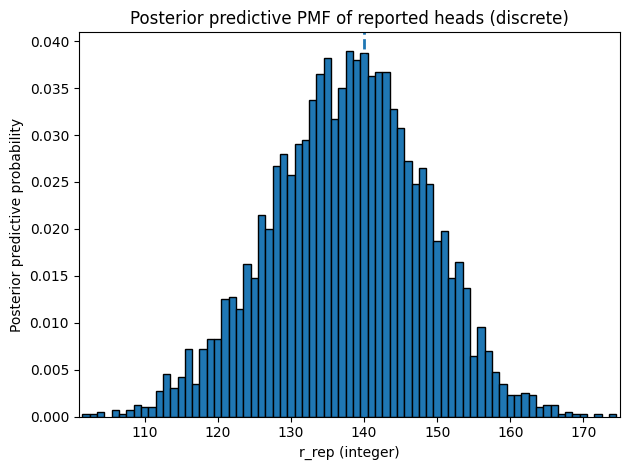

In [18]:

theta = draws["theta"].to_numpy()
q = draws["q"].to_numpy()
r_rep = draws["r_rep"].to_numpy()

def ci(x, a=0.05):
    lo, hi = np.quantile(x, [a/2, 1-a/2])
    return lo, hi

# Posterior theta plot
tmean = np.mean(theta)
tlo, thi = ci(theta)

plt.figure()
plt.hist(theta, bins=50, density=True)
plt.axvline(tmean, linestyle="--", linewidth=2)
plt.axvline(tlo, linestyle=":", color='red'); 
plt.axvline(thi, linestyle=":", color='red')
plt.axvline(0.5, linestyle="-.", linewidth=2, color='black')
plt.title("Posterior of θ (true head probability)")
plt.xlabel("θ"); plt.ylabel("Density")
plt.tight_layout(); plt.show()

# Discrete posterior predictive PMF
vals, cnts = np.unique(r_rep, return_counts=True)
pmf = cnts / cnts.sum()
plt.figure()
plt.bar(vals, pmf, width=1.0, align="center", edgecolor="black")
plt.axvline(r, linestyle="--", linewidth=2)  # observed r
plt.title("Posterior predictive PMF of reported heads (discrete)")
plt.xlabel("r_rep (integer)"); plt.ylabel("Posterior predictive probability")
plt.xlim(min(vals)-1, max(vals)+1)
plt.tight_layout(); plt.show()


## Bayes Factor and ROPE tests

In [14]:

import numpy as np
import pandas as pd
from scipy.special import logsumexp

N, r = 250, 140
y = 0.4
alpha, beta = 10.0, 10.0
theta0 = 0.5

# Bayes factor BF01: H0 theta=0.5 vs H1 Beta(10,10)
q0 = 0.5
log_m0 = r * np.log(q0) + (N - r) * np.log(1 - q0)  # binomial coefficient cancels
# Monte Carlo estimate of m1 under the Beta(10,10) prior
rng = np.random.default_rng(123)
M = 600_000
theta_prior = rng.beta(alpha, beta, size=M)
q_prior = y + (1 - 2*y) * theta_prior
q_prior = np.clip(q_prior, 1e-12, 1-1e-12)
loglik = r * np.log(q_prior) + (N - r) * np.log(1 - q_prior)
log_m1 = logsumexp(loglik) - np.log(M)

BF01 = np.exp(log_m0 - log_m1)
BF10 = 1.0 / BF01

print(f"BF01 (fair over not-fair): {BF01:.3f}")
print(f"BF10 (not-fair over fair): {BF10:.3f}")

# ROPE tests
def rope_probs(samples, center=0.5, halfwidth=0.02):
    lo, hi = max(0.0, center - halfwidth), min(1.0, center + halfwidth)
    pin = np.mean((samples >= lo) & (samples <= hi))
    pbelow = np.mean(samples < lo)
    pabove = np.mean(samples > hi)
    return lo, hi, pin, pbelow, pabove

for hw in [0.02, 0.05]:
    lo, hi, pin, pbelow, pabove = rope_probs(theta, center=0.5, halfwidth=hw)
    print(f"ROPE [{lo:.2f}, {hi:.2f}]  P(in)={pin:.3f},  P(<low)={pbelow:.3f},  P(>high)={pabove:.3f}")


BF01 (fair over not-fair): 0.674
BF10 (not-fair over fair): 1.483
ROPE [0.48, 0.52]  P(in)=0.027,  P(<low)=0.035,  P(>high)=0.938
ROPE [0.45, 0.55]  P(in)=0.068,  P(<low)=0.021,  P(>high)=0.911


## Save posterior samples

In [15]:

import pandas as pd
samples_path = "posterior_theta_strong_prior.csv"
pd.DataFrame({"theta": theta}).to_csv(samples_path, index=False)
print("Wrote", samples_path)


Wrote posterior_theta_strong_prior.csv
